In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)

import pandas as pd
import networkx as nx
import itertools

comp = pd.read_csv('./cleaned_data.csv')
comp.head()

Populating the interactive namespace from numpy and matplotlib


,officer_id,crid,incident_date,beat_2012_geocoded,complaintcategory,finalfinding,first.name,last.name,appointed.date,race,...,rank,primary,secondary,tertiary,categorycode,categoryf,date,day,month,year
0,1,1022797,01-Jan-2009 0:08,NaN,03G-MISCELLANEOUS,EX,JOHN,BARTUCH,2002-10-28,WHITE,...,POLICE OFFICER,0,0,1,03G,3,2009-01-01,1,1,2009
1,2,1022797,01-Jan-2009 0:08,NaN,03G-MISCELLANEOUS,EX,JUAN,CARDENAS,2005-10-31,HISPANIC,...,POLICE OFFICER,0,0,1,03G,3,2009-01-01,1,1,2009
2,2,1071057,16-Aug-2014 19:30,1031.0,03B-SEARCH OF PERSON WITHOUT WARRANT,NAF,JUAN,CARDENAS,2005-10-31,HISPANIC,...,POLICE OFFICER,0,0,1,03B,3,2014-08-16,16,8,2014
3,2,1065981,08-Nov-2013 16:30,NaN,10D-COMMUNICATION OPERATIONS PROCEDURES,NAF,JUAN,CARDENAS,2005-10-31,HISPANIC,...,POLICE OFFICER,0,0,1,10D,5,2013-11-08,8,11,2013
4,3,1022797,01-Jan-2009 0:08,NaN,03G-MISCELLANEOUS,EX,JOSEPH,CEGLAREK,2006-10-30,WHITE,...,POLICE OFFICER,0,1,0,03G,3,2009-01-01,1,1,2009


In [3]:
grouped = comp.groupby('crid')
grouped.get_group(1068169)

,officer_id,crid,incident_date,beat_2012_geocoded,complaintcategory,finalfinding,first.name,last.name,appointed.date,race,...,rank,primary,secondary,tertiary,categorycode,categoryf,date,day,month,year
8952,1655,1068169,24-Mar-2014 0:30,612.0,10D-COMMUNICATION OPERATIONS PROCEDURES,NAF,MICHAEL,DEARBORN,2008-04-28,BLACK,...,POLICE OFFICER,0,0,1,10D,5,2014-03-24,24,3,2014
11731,2589,1068169,24-Mar-2014 0:30,612.0,10D-COMMUNICATION OPERATIONS PROCEDURES,NAF,AJAMUGOM,JOHNSON,2003-04-28,BLACK,...,POLICE OFFICER,0,1,0,10D,5,2014-03-24,24,3,2014


In [2]:
def do_time(comp):
    bpt = nx.Graph()
    
    grouped = comp.groupby('crid')
    for x in grouped.groups.keys():
        df = grouped.get_group(x)
        
        #let's make these large for now
        time = df.year.iloc[0]
        category = df.categoryf.iloc[0]
        
        officers = list(df.officer_id)
        for (a,b) in list(itertools.combinations(officers, 2)):
            bpt.add_edge(a, b, time=time, category=category)
    
    return bpt
        

In [3]:
def do_it(comp):
    bpt = nx.Graph()
    
    for index, row in comp.iterrows():
        officer, cr, time = row.officer_id, row.crid, row.incident_date
        bpt.add_edge(officer, cr)

    # project this graph to (OFFICER <--(crime)--> OFFICER)
    G = nx.bipartite.collaboration_weighted_projected_graph(bpt, comp.officer_id.unique())
    
    H = nx.bipartite.collaboration_weighted_projected_graph(bpt, comp.crid.unique())
    return G,H

In [4]:
K = do_time(comp)

In [5]:
K[K.edges()[953][0]]

{43: {'category': 1, 'time': 2012},
 49: {'category': 3, 'time': 2009},
 111: {'category': 1, 'time': 2012},
 114: {'category': 1, 'time': 2009},
 116: {'category': 1, 'time': 2012},
 125: {'category': 2, 'time': 2009},
 395: {'category': 1, 'time': 2012},
 456: {'category': 3, 'time': 2013},
 827: {'category': 3, 'time': 2013},
 856: {'category': 3, 'time': 2013},
 947: {'category': 3, 'time': 2013},
 1030: {'category': 5, 'time': 2013},
 1165: {'category': 5, 'time': 2013},
 1315: {'category': 3, 'time': 2011},
 1423: {'category': 3, 'time': 2013},
 1437: {'category': 3, 'time': 2013},
 2208: {'category': 1, 'time': 2011},
 2479: {'category': 1, 'time': 2011},
 2583: {'category': 5, 'time': 2011},
 3071: {'category': 3, 'time': 2013},
 3072: {'category': 3, 'time': 2013},
 3073: {'category': 3, 'time': 2013}}

In [6]:
from collections import Counter

def drop_zeros(a_list):
    return [i for i in a_list if i>0]

def log_binning(counter_dict,bin_count=35):

    max_x = log10(max(counter_dict.keys()))
    max_y = log10(max(counter_dict.values()))
    max_base = max([max_x,max_y])

    min_x = log10(min(drop_zeros(counter_dict.keys())))

    bins = np.logspace(min_x,max_base,num=bin_count)

    # Based off of: http://stackoverflow.com/questions/6163334/binning-data-in-python-with-scipy-numpy
    bin_means_y = (np.histogram(counter_dict.keys(),bins,weights=counter_dict.values())[0] / np.histogram(counter_dict.keys(),bins)[0])
    bin_means_x = (np.histogram(counter_dict.keys(),bins,weights=counter_dict.keys())[0] / np.histogram(counter_dict.keys(),bins)[0])

    return bin_means_x,bin_means_y

def plot_degree(G):

    ba_c = nx.degree_centrality(G)
    # To convert normalized degrees to raw degrees
    #ba_c = {k:int(v*(len(ba_g)-1)) for k,v in ba_c.iteritems()}
    ba_c2 = dict(Counter(ba_c.values()))

    ba_x,ba_y = log_binning(ba_c2,50)

    plt.xscale('log')
    plt.yscale('log')
    plt.scatter(ba_x,ba_y,c='r',marker='s',s=50)
    plt.scatter(ba_c2.keys(),ba_c2.values(),c='b',marker='x')
    plt.xlim((1e-4,1e-1))
    plt.ylim((.9,1e4))
    plt.xlabel('Connections (normalized)')
    plt.ylabel('Frequency')
    plt.show()

# Exploring 2009 data

In [7]:
G, H = do_it(comp[comp.year == 2009])

In [8]:
G[G.edges()[953][0]]

{165: {'weight': 1.325},
 218: {'weight': 0.125},
 619: {'weight': 2.125},
 701: {'weight': 0.5},
 702: {'weight': 0.825},
 822: {'weight': 0.325},
 823: {'weight': 0.325},
 882: {'weight': 1.0},
 1286: {'weight': 0.125},
 1287: {'weight': 0.125},
 1314: {'weight': 0.2}}

/home/foxtrot/.virtualenvs/sis/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in divide
/home/foxtrot/.virtualenvs/sis/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in divide


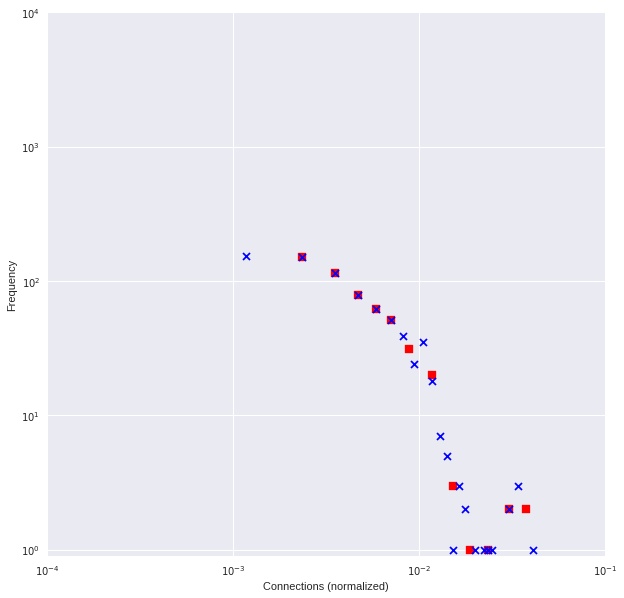

In [9]:
plot_degree(H)

In [13]:
comp.categoryf.describe()

count    13840.000000
mean         2.962355
std          1.459163
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: categoryf, dtype: float64

In [10]:
def get_color(officer_id):
    if comp.primary[officer_id] == 1:
        return 'r'
    elif comp.secondary[officer_id] == 1:
        return 'purple'
    elif comp.tertiary[officer_id] == 1:
        return 'b'

def get_colorh(complaint_id):
    a = comp.categoryf[comp.crid == complaint_id].iloc[0]
    if a == 1:
        return 'red'
    return 'black'

In [15]:
positionsG = nx.spring_layout(G)

In [16]:
positions = nx.spring_layout(H)

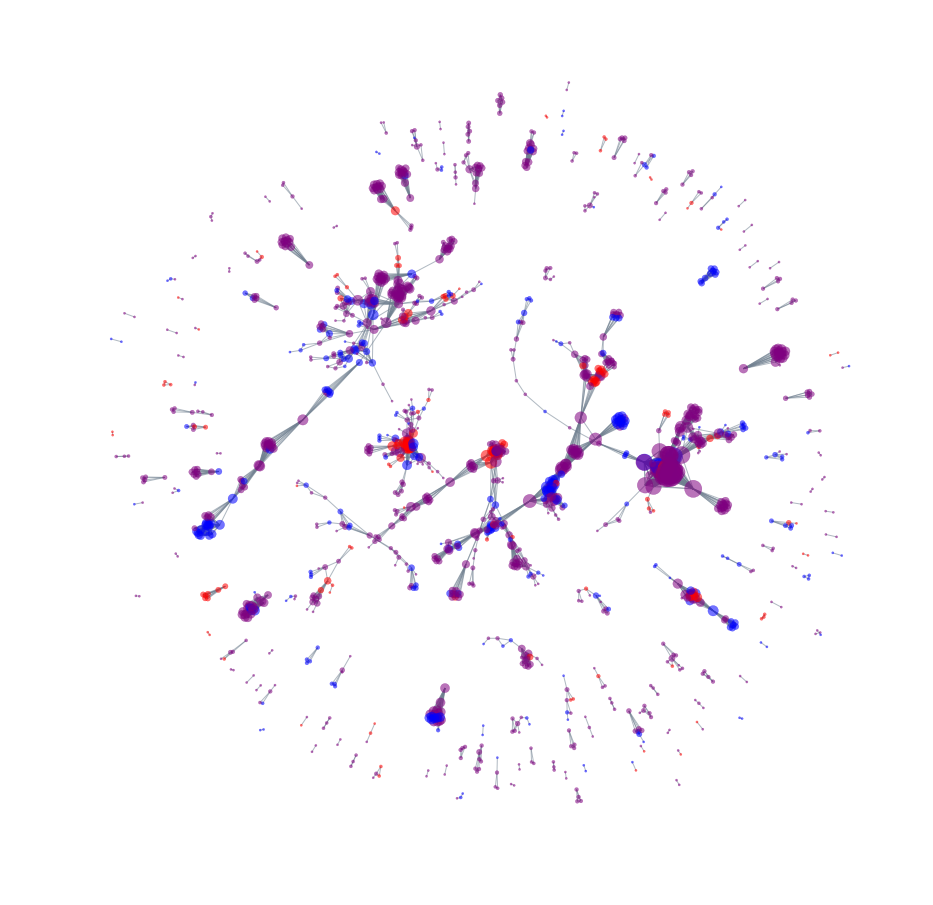

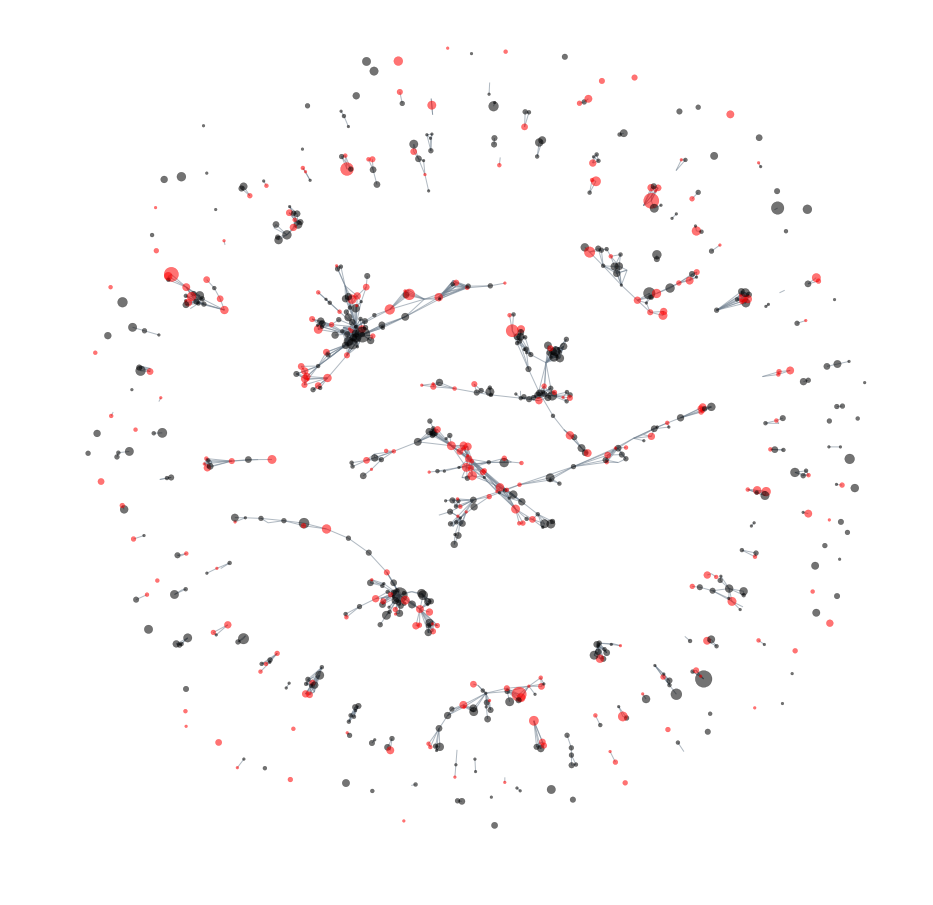

In [159]:
plt.figure(figsize=(16,16))
sns.set(font_scale = 1.4)
nx.draw_networkx_nodes(G, pos=positionsG,
                     node_color = [get_color(i) for i in G.nodes()],
                     node_size = [5*x for x in G.degree().values()],
                     alpha = 0.55)
nx.draw_networkx_edges(G, pos=positionsG,
                      edge_color = 'slategray', alpha=0.55)


# # There is no labels, need to define the labels
# legend_labels  = ['Primary Severity', 'Secondary Severity', 'Tertiary Severity']

# # Create the legend patches
# legend_patches = [matplotlib.patches.Patch(color=C, label=L) for
#                   C, L in zip(['red', 'purple', 'blue'],
#                               legend_labels)]

# # Plot the legend
# plt.legend(handles=legend_patches)


# plt.title('Network of Officers Involved in Misconducts')
plt.axis('off')
plt.savefig('officers_2009.png', transparent=True)
plt.figure(figsize=(16,16))

nx.draw_networkx_nodes(H, pos=positions,
                     node_color = [get_colorh(i) for i in H.nodes()],
                     node_size = [8*x for x in H.degree().values()],
                     alpha = 0.55)
nx.draw_networkx_edges(H, pos=positions,
                      edge_color = 'slategray', alpha=0.55)


# # There is no labels, need to define the labels
# legend_labels  = ['Violent', 'Less Violent']

# # Create the legend patches
# legend_patches = [matplotlib.patches.Patch(color=C, label=L) for
#                   C, L in zip(['red', 'black'],
#                               legend_labels)]

# # Plot the legend
# plt.legend(handles=legend_patches)

# plt.title('Network of Misconducts, Linked by Officers')
plt.axis('off')
plt.savefig('issues_2009.png', transparent = True)
plt.show()

# Part 2: Temporal Network Analysis

We also want to know which officers are more likely to lead others down the path of oppression. Towards this end, I tried to get the second-order temporal network, in which edges connect an officer to others who are complained about the next year. Using this data, we might be able to see which some officers are more likely to *become* violent, by training on incoming edges.

The way we get this temporal graph is by a random walk. Earlier, we associated the edges of the graph between officers (which represent complaints involving both of them) with timestamps. Now, we'll use these timesteps in a random walk.

In [11]:
import random


def printedge(edge):
    print edge

def random_walker(K):
    associations = []
    
    start = random.choice(K.nodes())
#     print 'Neighbors:', K[start]
    
    # pick the first node
    n = random.choice(K[start].keys())
    time0 = K[start][n]['time']
#     print 'Year:', time0
    
    # travel to that node
    start = n
#     print 'Traveled to', start, printedge(K[start])
    
#     print '-'*15
    tries = 0
    
    while tries < 5:
        n = random.choice(K[start].keys())
        time = K[start][n]['time']
        if time - time0 == 1:
            associations.append((start, n))
            tries = 0
            
        start = n
#         print 'Traveled to', start, printedge(K[start])
        tries += 1
    
    return associations

causality = []
for x in range(30):
    print 'Trial:', x
    print len(set(causality))
    for y in range(2000):
        causality += random_walker(K)


Trial: 0
0
Trial: 1
1691
Trial: 2
3019
Trial: 3
4441
Trial: 4
5745
Trial: 5
7020
Trial: 6
8244
Trial: 7
9459
Trial: 8
10569
Trial: 9
11594
Trial: 10
12560
Trial: 11
13507
Trial: 12
14418
Trial: 13
15246
Trial: 14
16073
Trial: 15
16888
Trial: 16
17630
Trial: 17
18212
Trial: 18
18802
Trial: 19
19439
Trial: 20
20039
Trial: 21
20584
Trial: 22
21122
Trial: 23
21636
Trial: 24
22124
Trial: 25
22533
Trial: 26
22896
Trial: 27
23279
Trial: 28
23664
Trial: 29
24061


In [12]:
causality_graph = nx.DiGraph()
causality_graph.add_edges_from(set(causality))
causality_graph.to_directed()

/home/foxtrot/.virtualenvs/sis/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in divide
/home/foxtrot/.virtualenvs/sis/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in divide


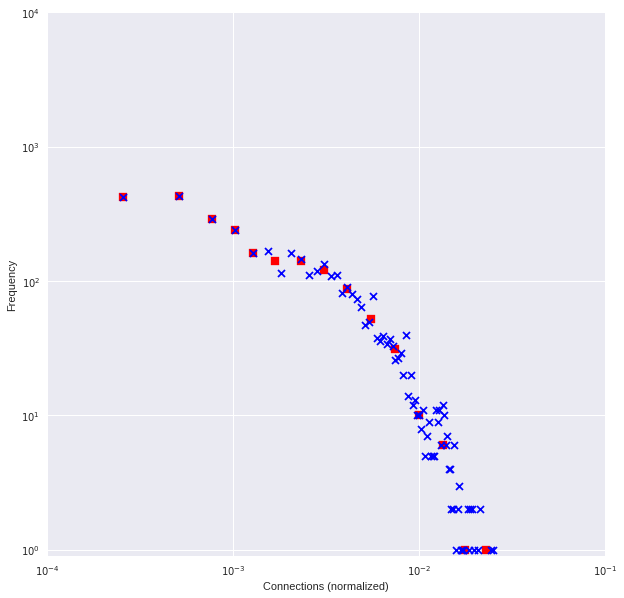

In [13]:
plot_degree(K)

/home/foxtrot/.virtualenvs/sis/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in divide
/home/foxtrot/.virtualenvs/sis/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in divide


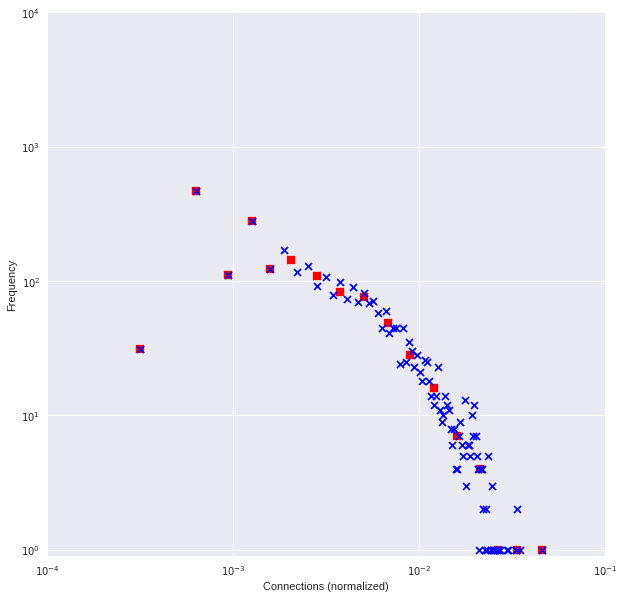

In [14]:
plot_degree(causality_graph)

In [15]:
not_causal = [i for i in causality_graph.nodes() if causality_graph.out_degree()[i] < 5]
len(not_causal)

1473

In [16]:
causality_graph.remove_nodes_from(not_causal)

In [17]:
MONSTER = nx.spring_layout(causality_graph, scale=2.0)

In [217]:
CORE = nx.k_core(causality_graph, core_number=)
MONSTER_BRAIN = nx.spring_layout(CORE, scale=2.0)

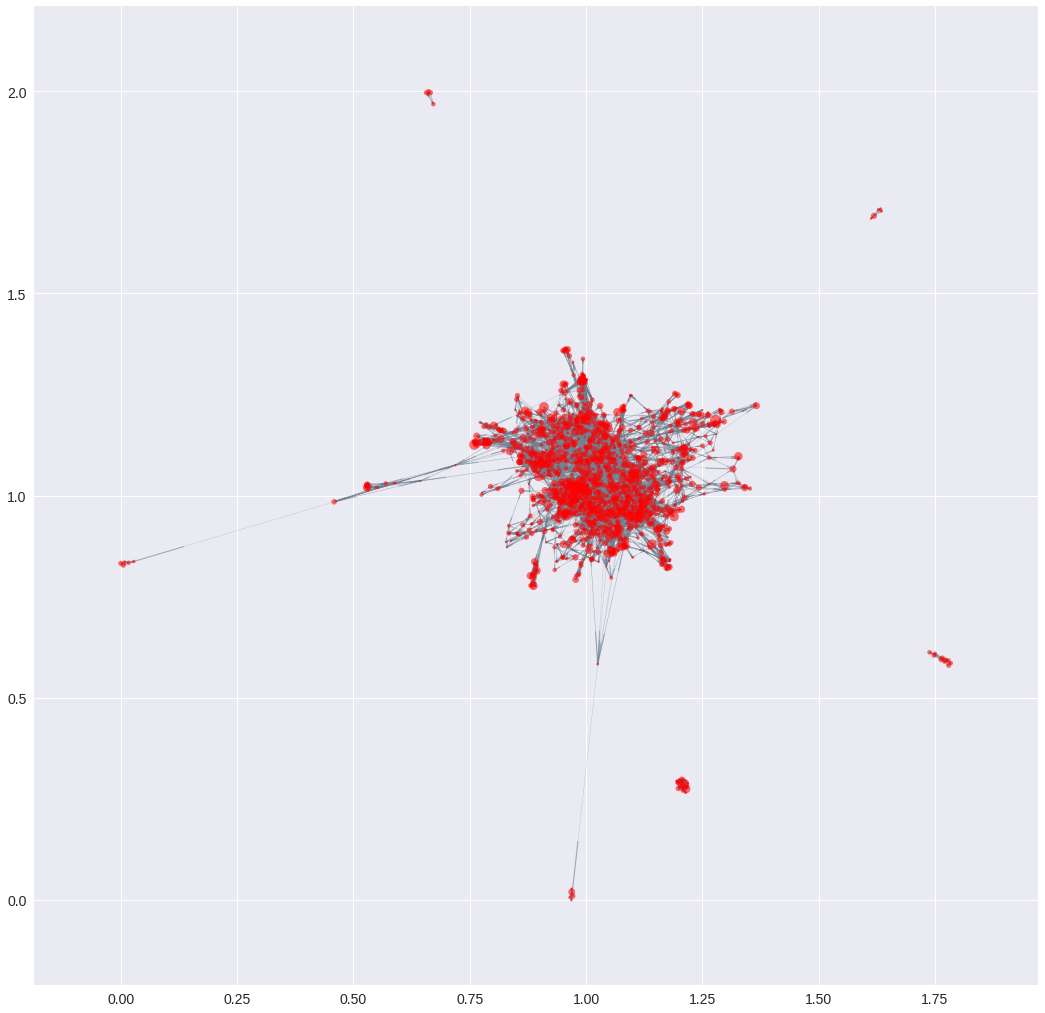

In [218]:
plt.figure(figsize=(18,18))
nx.draw_networkx_nodes(CORE, pos=MONSTER_BRAIN, 
                       alpha = 0.55, node_size=[i for i in causality_graph.degree().values()])

nx.draw_networkx_edges(CORE, pos=MONSTER_BRAIN, 
                       edge_color='slategray', alpha=0.5, width=0.3)

That didn't help at all...

## Community detection algorithms

In [33]:
import community


#first compute the best partition
partition = community.best_partition(causality_graph.to_undirected())

size = float(len(set(partition.values())))
Counter(partition.values())

Counter({0: 141,
         1: 80,
         2: 105,
         3: 82,
         4: 191,
         5: 83,
         6: 126,
         7: 67,
         8: 64,
         9: 67,
         10: 51,
         11: 109,
         12: 16,
         13: 77,
         14: 49,
         15: 144,
         16: 19,
         17: 82,
         18: 12,
         19: 69,
         20: 20,
         21: 10,
         22: 24,
         23: 1,
         24: 12,
         25: 1,
         26: 3})

In [69]:
colors_sns_officers[partition[80]]

(0.86, 0.4826285714285714, 0.33999999999999997)

18.3280254777


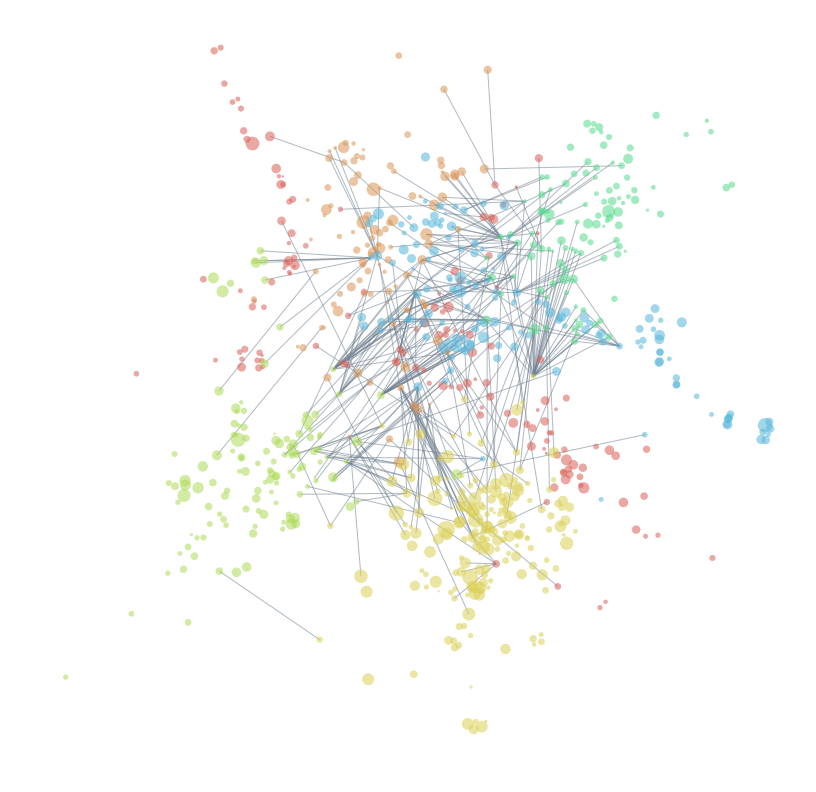

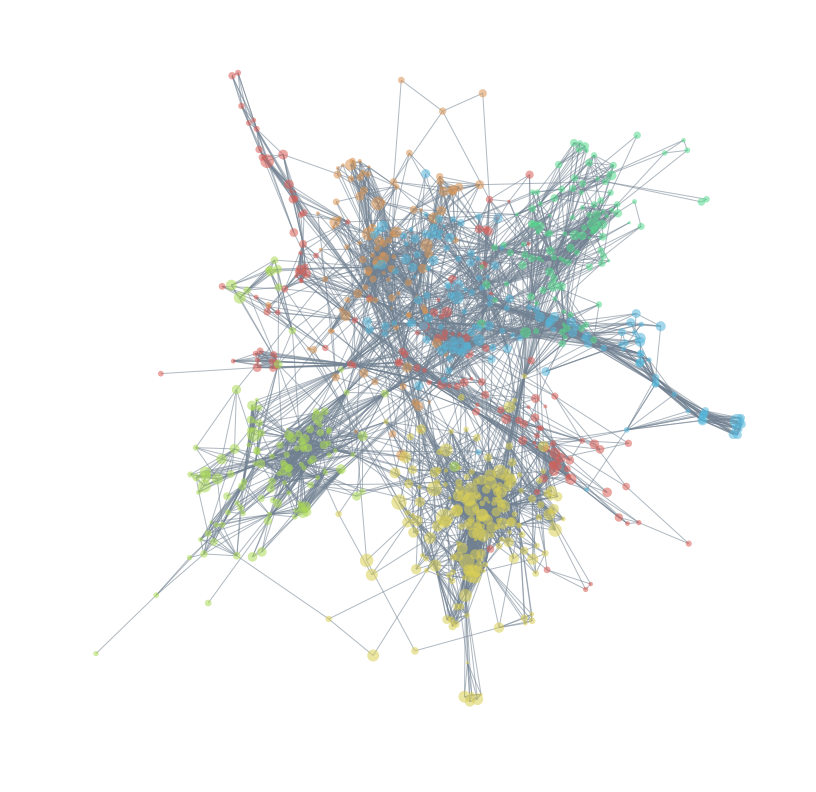

In [108]:
colors_sns_officers = sns.color_palette("hls", len(set(partition.values()))+1)

components = [0, 2, 4, 6, 11, 15]
total_nodes = [nodes for nodes in partition.keys() if partition[nodes] in components]
pos = nx.spring_layout(total_subgraph)

total_subgraph = causality_graph.subgraph(total_nodes).to_undirected()
beginning = len(total_subgraph.edges())

plt.figure(figsize=(14,14))
for i in components:
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == i]
    
    color = colors_sns_officers[i]
    part0 = causality_graph.subgraph(list_nodes).to_undirected()
    
    total_subgraph.remove_edges_from(part0.edges())
    nx.draw_networkx_nodes(part0, pos, nodelist=list_nodes,
                           node_size=[4*i for i in part0.degree().values()],
                           node_color = color,
                           alpha = 0.55)
    

end = len(total_subgraph.edges())
print beginning/float(end)
nx.draw_networkx_edges(total_subgraph, pos, alpha = 0.55, edge_color = 'slategray')

plt.axis('off')
plt.savefig('edges_reduced.png', transparent = True)
plt.show()

# do it again, but without removing edges
total_subgraph = causality_graph.subgraph(total_nodes).to_undirected()

plt.figure(figsize=(14,14))
for i in components:
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == i]
    
    color = colors_sns_officers[i]
    part0 = causality_graph.subgraph(list_nodes).to_undirected()
    
    nx.draw_networkx_nodes(part0, pos, nodelist=list_nodes,
                           node_size=[4*i for i in part0.degree().values()],
                           node_color = color,
                           alpha = 0.55)
    

nx.draw_networkx_edges(total_subgraph, pos, alpha = 0.55, edge_color = 'slategray')

plt.axis('off')
plt.savefig('edges_all.png', transparent = True)
plt.show()

In [ ]:
plt.figure(figsize=(18,18))
count = 0.
for com in [3] :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(causality_graph, pos=MONSTER, nodes=list_nodes,
                           alpha = 0.55, 
                           node_size=[i for i in causality_graph.degree().values()],
                           node_color = str(count / size))


nx.draw_networkx_edges(causality_graph, pos=MONSTER, 
                       edge_color='slategray', alpha=0.5, width=0.3)


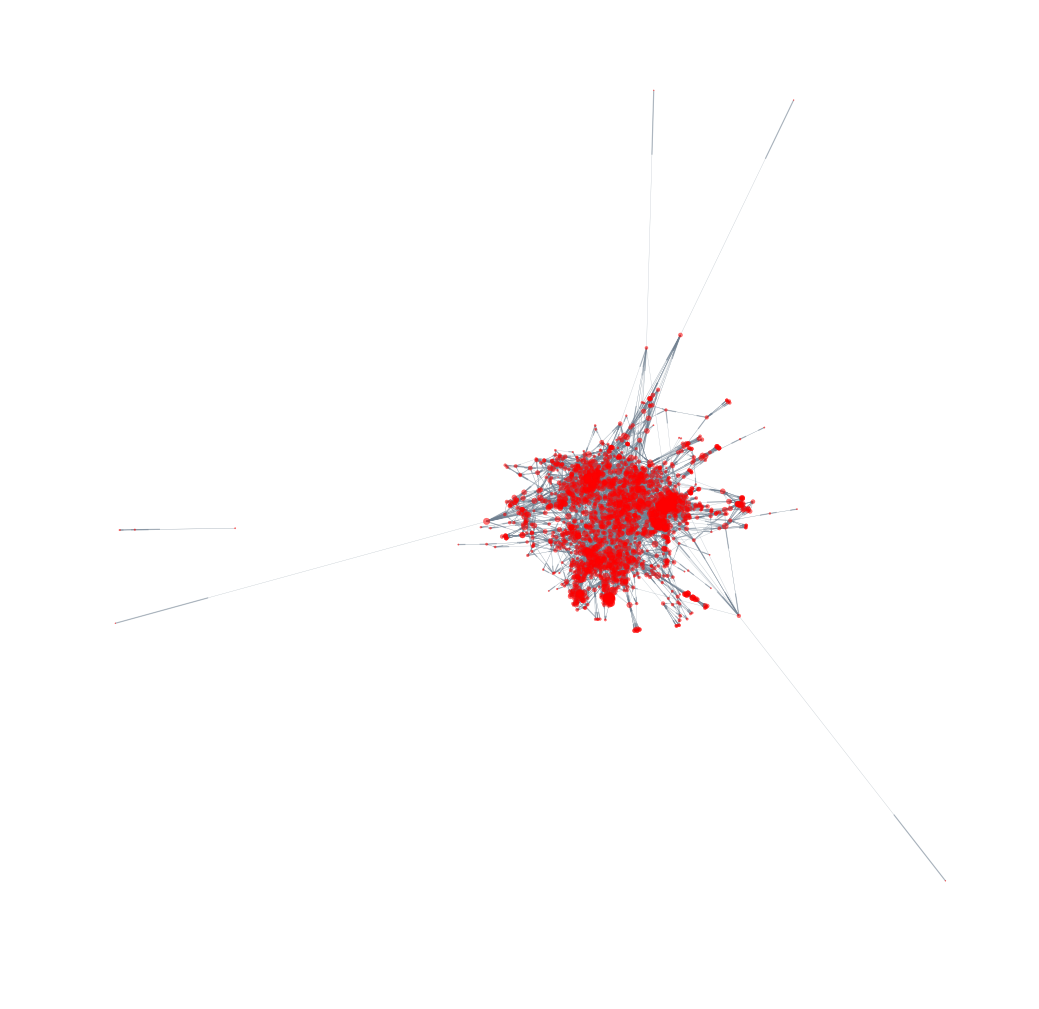

In [45]:
plt.figure(figsize=(18,18))
nx.draw_networkx_nodes(causality_graph, pos=MONSTER, 
                       alpha = 0.55, node_size=[i for i in causality_graph.degree().values()])

nx.draw_networkx_edges(causality_graph, pos=MONSTER, 
                       edge_color='slategray', alpha=0.5, width=0.3)


plt.axis('off')
plt.savefig('causal_net.png', transparent = True)
plt.show()

In [100]:
graphs = {}
for x in [2009, 2010, 2011, 2012, 2013, 2014, 2015]:
    temp = nx.Graph()
    edges = [i for i in K.edges(data=True) if i[2]['time'] == x]
    for (a, b, att) in edges:
        temp.add_edge(a, b)
        
    graphs[x] = temp
    

In [63]:
components_G = nx.connected_component_subgraphs(G)
large_components = [i for i in components_G if len(i.nodes()) > 2]
len(large_components)

91

In [145]:
print len(G.nodes())
print len(K.nodes())

1435
3884


In [87]:
nx.write_edgelist(K, "officers_only.edgelist", data=False)